<a href="https://colab.research.google.com/github/WhiteHum/Medical-AI-Deep-Learning-Drug-Toxicitiy-Prediction-/blob/main/07_CRISPR_Repair_Outcome_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

학습 전 세팅

필요한 라이브러리 설치하기

In [1]:
!pip install PyTDC
!pip install lifelines

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


데이터 불러오기

In [2]:
from tdc.utils import retrieve_label_name_list
label_list = retrieve_label_name_list('Leenay')

In [3]:
from tdc.single_pred import CRISPROutcome
data = CRISPROutcome(name='Leenay', label_name = label_list[0])
split = data.get_split()

Found local copy...
Loading...
Done!


In [4]:
# 나누어진 데이터 확인 
split.keys()

dict_keys(['train', 'valid', 'test'])

In [5]:
# Train data
split['train']

,GuideSeq_ID,GuideSeq,Y
0,GuideSeq 1,CTGCAGGGCTAGTTTCCTATAGG,0.069572
1,GuideSeq 2,GAGATGCGGACCACCCAGCTGGG,0.287647
2,GuideSeq 3,GCAAACGGAAGTGCAATTGTCGG,0.137004
3,GuideSeq 4,GTCATCGCTGAGTTGAGGAAGGG,0.093889
4,GuideSeq 5,ATATGATTATCCCTGCACAAGGG,0.526525
...,...,...,...
1060,GuideSeq 1517,ATGCCCGACCAAAGACAACCAGG,0.093236
1061,GuideSeq 1518,CACGCTGTCATCCACCAGGTAGG,0.069054
1062,GuideSeq 1519,GGGCTCCAGAGTCTGATACAGGG,0.421439
1063,GuideSeq 1520,AAAGACTTCGGTCCTCTAGTAGG,0.206277


In [6]:
split['train']['GuideSeq'].apply(len)

0       23
1       23
2       23
3       23
4       23
        ..
1060    23
1061    23
1062    23
1063    23
1064    23
Name: GuideSeq, Length: 1065, dtype: int64

In [7]:
# Train data
split['valid']

,GuideSeq_ID,GuideSeq,Y
0,GuideSeq 841,CCTTGTGAATCTCCTCACGGAGG,0.394674
1,GuideSeq 101,CGCTTTACCTGCGACCAGGTAGG,0.072320
2,GuideSeq 235,CATTCTCCAAGTGACAAGGTAGG,0.049883
3,GuideSeq 162,CTTGGTCATGCCTTCCCGGTAGG,0.206285
4,GuideSeq 421,AAAGTACTCGAAGTATTCTTGGG,0.061223
...,...,...,...
147,GuideSeq 986,TTTACTCTCAGAAACCTACCTGG,0.113981
148,GuideSeq 744,GATGAGGCCTGTAGAGACGTAGG,0.092636
149,GuideSeq 1447,TTGCCTACTCACTTCCTTGGAGG,0.211790
150,GuideSeq 521,CTATCCCTCACGATGGAAGTAGG,0.089396


In [8]:
# Test data
split['test']

,GuideSeq_ID,GuideSeq,Y
0,GuideSeq 567,TGTGCAATATCTGGTACTAAGGG,0.176660
1,GuideSeq 1102,TGTCTGGCCAGCAGAATACAGGG,0.300800
2,GuideSeq 1474,ACTGAGAGTGGATCCGAAAGTGG,0.153200
3,GuideSeq 1178,GTTCTGCACCAGCACATTCACGG,0.192665
4,GuideSeq 1010,ACTGGATGGACAAGACTGGTGGG,0.229076
...,...,...,...
299,GuideSeq 1413,TATGAAGCATGGGTCTGAGTCGG,0.108374
300,GuideSeq 721,ATGTTGGACAGCTGCCCGGTGGG,0.203401
301,GuideSeq 234,GACCAGGGCCACATCTTTAAAGG,0.143219
302,GuideSeq 894,AGTAGACTGACCTGGTAGGAGGG,0.200965


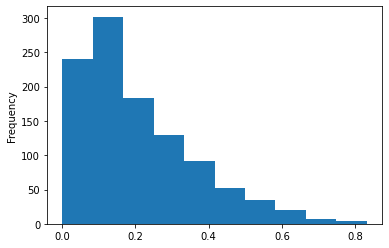

In [9]:
split['train']['Y'].plot.hist()

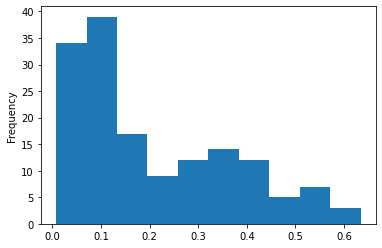

In [10]:
split['valid']['Y'].plot.hist()

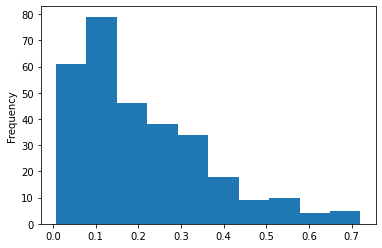

In [11]:
split['test']['Y'].plot.hist()

데이터 전처리 및 torch dataloader 만들기

In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

In [13]:
class SeqProcessor :
  def __init__(self, char, max_seq):
    # One-hot encodeing에 사용할 character 정의
    self.char = char
    # One-hot 인코더 fitting
    self.enc_dna = OneHotEncoder().fit(np.array(self.char).reshape(-1, 1))
    # Sequence 최대 길이
    self.max_seq = max_seq

# Protein sequence 데이터 전처리
# 모든 sequence를 같은 크기의 리스트로 만들고 사정에 정의된 character에 해당되지 않는 값은 ?로 반환함
  def trans_dna(self, x : str) -> list :
    temp = list(x.upper()) # 대문자로 바꾸기
    temp = [i if i in self.char else '?' for i in temp]

    if len(temp)< self.max_seq :
    # MAX_SEQ_DNA 보다 작으면 뒷부분을 ? 로 채워서 MAX_SEQ_DRUG 만큼 슬라이싱
      temp = temp + ['?'] * (self.max_seq - len(temp))
    else :
    # MAX_SEQ_DNA 보다 크면 앞에서부터 MAX_SEQ_DRUG 만큼 슬라이싱
      temp = temp[:self.max_seq]
    return temp

  def dna_2_embed(self, x:list) -> np.ndarray:
    return self.enc_dna.transform(np.array(x).reshape(-1, 1)).toarray().T

In [14]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

In [15]:
# Custom dataset 만들기

class data_process_loader(Dataset):
  def __init__(self, df:pd.DataFrame, sp:SeqProcessor) :
    self.sp = sp
    self.df = df

  def __len__(self):
    return self.df.shape[0]

  def __getitem__(self, index):
    # Target 데이터
    v_s = self.df.iloc[index]['GuideSeq']
    v_s = self.sp.trans_dna(v_s)
    v_s = self.sp.dna_2_embed(v_s) # Target One-hot 인코딩 [26, 100]

    # Binding affinity (label)
    y = self.df.iloc[index]['Y']

    return v_s, y

In [16]:
# defince processor for dna sequence
dna_char = ['?', 'A', 'T', 'G', 'C']
max_seq = 23

sp = SeqProcessor(dna_char, max_seq)

In [17]:
train_dataset = data_process_loader(split['train'], sp)
valid_dataset = data_process_loader(split['valid'], sp)
test_dataset = data_process_loader(split['test'], sp)

In [18]:
# DataLoader를 위한 hyperparameter 설정

params = { 'batch_size' : 64,
          'shuffle' : True,
          'num_workers' : 1,
          'drop_last': False}

training_generator = DataLoader(train_dataset, **params)
valid_generator = DataLoader(valid_dataset, **params)
test_generator = DataLoader(test_dataset, **params)

In [19]:
# Dataloader 확인해 보기

for (v_s, y) in training_generator:
  print(v_s.shape)
  print(y)
  break

torch.Size([64, 5, 23])
tensor([0.1997, 0.4046, 0.1118, 0.0839, 0.3723, 0.0880, 0.3684, 0.3215, 0.1294,
        0.0317, 0.0871, 0.1902, 0.4203, 0.0788, 0.5677, 0.4529, 0.5284, 0.2607,
        0.5120, 0.1148, 0.1607, 0.1340, 0.5647, 0.3391, 0.4399, 0.2365, 0.4395,
        0.1274, 0.1399, 0.7110, 0.3844, 0.2569, 0.2743, 0.0585, 0.0861, 0.1030,
        0.5795, 0.5491, 0.3238, 0.3891, 0.1197, 0.5936, 0.1018, 0.2570, 0.0297,
        0.0884, 0.6025, 0.5445, 0.2842, 0.2670, 0.5125, 0.0249, 0.1900, 0.4545,
        0.1451, 0.1143, 0.1070, 0.1614, 0.1488, 0.4757, 0.0583, 0.0347, 0.1751,
        0.1224], dtype=torch.float64)


In [20]:
for (v_s, y) in valid_generator:
  print(v_s.shape)
  print(y)
  break

torch.Size([64, 5, 23])
tensor([0.0538, 0.0417, 0.1060, 0.2522, 0.1805, 0.0687, 0.3148, 0.3815, 0.1120,
        0.1213, 0.1296, 0.0311, 0.3088, 0.2276, 0.4459, 0.0496, 0.0926, 0.5262,
        0.0556, 0.0695, 0.0723, 0.0663, 0.4273, 0.3423, 0.5307, 0.0231, 0.3253,
        0.0843, 0.3341, 0.0946, 0.2934, 0.0656, 0.0631, 0.1677, 0.0632, 0.5188,
        0.5004, 0.4019, 0.1482, 0.1222, 0.3736, 0.3225, 0.0843, 0.6341, 0.4588,
        0.4078, 0.1202, 0.4994, 0.1026, 0.1542, 0.3805, 0.0361, 0.5224, 0.2063,
        0.5707, 0.4433, 0.1586, 0.0699, 0.0079, 0.2473, 0.1706, 0.3857, 0.2985,
        0.3210], dtype=torch.float64)


In [21]:
for (v_s, y) in test_generator:
  print(v_s.shape)
  print(y)
  break

torch.Size([64, 5, 23])
tensor([0.4761, 0.0399, 0.1830, 0.3966, 0.0884, 0.0073, 0.6468, 0.1008, 0.0335,
        0.3335, 0.2811, 0.1845, 0.2043, 0.2928, 0.1098, 0.1029, 0.5326, 0.0510,
        0.0547, 0.1779, 0.0553, 0.2939, 0.2796, 0.0281, 0.5081, 0.0423, 0.0763,
        0.1154, 0.1189, 0.1883, 0.0913, 0.1767, 0.3924, 0.3926, 0.2731, 0.0520,
        0.1007, 0.2907, 0.1246, 0.0701, 0.2433, 0.1000, 0.3123, 0.0391, 0.0570,
        0.3128, 0.1633, 0.2046, 0.2034, 0.0225, 0.0997, 0.2224, 0.0831, 0.1502,
        0.2332, 0.4597, 0.2970, 0.0225, 0.1062, 0.1600, 0.2451, 0.0193, 0.1863,
        0.0987], dtype=torch.float64)


학습에 사용할 모델 만들기

In [22]:
# 모델 설정 값

config = {
    # dna embedding layer 설정
    "cnn_filters" : [32, 64, 96],
    "cnn_kernels" : [3,3,3],
    "hidden_dim" : 256,
    "rnn_hid_dim" : 64,
    "rnn_n_layers" : 2,
    "rnn_bidirectional" : True,
    "rnn_Use_GRU_LSTM" : "GRU",

    # Classifier 설정
    "cls_hidden_dims" : [1024, 512]
}

In [23]:
class CNN_RNN(nn.Sequential):
  def __init__(self, **config):
    super(CNN_RNN, self).__init__()
    self.config = config
    
    # CNN 구현
    # 레이어 별 CNN 필터 개수
    in_ch = [5] + config['cnn_filters']
    self.in_ch = in_ch[-1] #마지막 convolution 층 필터 개수

    # 레이어 별 CNN kernel 사이즈
    kernels = config['cnn_kernels']

    # 전체 CNN Layer 개수
    layer_size = len(config['cnn_filters'])
    self.conv = nn.ModuleList([nn.Conv1d(in_channels = in_ch[i], # input 채널 수
                                         out_channels = in_ch[i+1], # output 채널 수
                                         kernel_size = kernels[i]) for i in range(layer_size)]) # kernel 사이즈
    
    self.conv = self.conv.double()

    # 마지막 층 사이즈 구하기
    n_size_d = self._get_conv_output((5,23)) 

    # RNN 구현
    if config['rnn_Use_GRU_LSTM'] == 'LSTM':
      self.rnn = nn.LSTM(input_size = in_ch[-1],
                         hidden_size = config['rnn_hid_dim'],
                         num_layers= config['rnn_n_layers'],
                         batch_first = True,
                         bidirectional = config['rnn_bidirectional'])
      
    elif config['rnn_Use_GRU_LSTM'] == 'GRU':
      self.rnn = nn.GRU(input_size = in_ch[-1],
                         hidden_size = config['rnn_hid_dim'],
                         num_layers= config['rnn_n_layers'],
                         batch_first = True,
                         bidirectional = config['rnn_bidirectional'])
    else :
      raise AttributeError('Please use LSTM or GRU')

    direction = 2 if config['rnn_bidirectional'] else 1
    self.rnn = self.rnn.double()

    # 마지막 drug 임데딩 층
    self.fc1 = nn.Linear(config['rnn_hid_dim'] * direction * n_size_d, config['hidden_dim'])
    
  def _get_conv_output(self, shape):
    bs = 1
    input = Variable(torch.rand(bs, *shape))
    output_feat = self._forward_features(input.double())
    n_size = output_feat.data.view(bs, self.in_ch, -1).size(2)
    return n_size

  def _forward_features(self, x) : 
    for l in self.conv:
      x = F.relu(l(x))
    return x

  def forward(self, v):
    v = self._forward_features(v.double())
    batch_size = v.size(0)
    v = v.view(batch_size, v.size(2), -1)

    if self.config['rnn_Use_GRU_LSTM'] == 'LSTM' : 
      direction = 2 if self.config['rnn_bidirectional'] else 1
      h0 = torch.randn(self.config['rnn_n_layers'] * direction, batch_size, self.config['rnn_hid_dim']).to(device) # Initialize hidden state
      c0 = torch.randn(self.config['rnn_n_layers'] * direction, batch_size, self.config['rnn_hid_dim']).to(device) # Initialize cell state
      v, (hn, cn) = self.rnn(v.double(), (h0.double(), c0.double()))
    else : 
      direction = 2 if self.config['rnn_bidirectional'] else 1
      h0 = torch.randn(self.config['rnn_n_layers'] * direction, batch_size, self.config['rnn_hid_dim']).to(device) # Initialize hidden state
      v, hn = self.rnn(v.double(), h0.double())

    v = torch.flatten(v, 1)
    v = self.fc1(v.float())
    return v

In [24]:
# 임데딩 된 drug와 protein 을 이용하여 classification
class Classifier(nn.Sequential) : 
  
  # model_drug :drug emebedding 모델
  # model_protein : protein emebedding 모델
  # config : 모델 설정 값
  def __init__(self, model_dna, **config):
    super(Classifier, self).__init__()
    self.input_dim = config['hidden_dim'] # drug feature 사이즈
    self.model_dna = model_dna # drug 임베딩 모델
    self.dropout = nn.Dropout(0.1) # dropout 적용
    self.hidden_dims = config['cls_hidden_dims'] # cliassifier hidden dimensions

    layer_size = len(self.hidden_dims) +1 # hidden layer 개수
    dims = [self.input_dim] + self.hidden_dims +[1] # ["합쳐진 feature 차원 (drug + protein), hidden1, hidden2, hidden3, 1 (output layer)] 
    self.predictor = nn.ModuleList([nn.Linear(dims[i], dims[i+1]) for i in range(layer_size)]) # classifier layers

  def forward(self, v_s) : 
    # Drug / protein 임베딩
    v_s = self.model_dna(v_s)

    for i, l in enumerate(self.predictor):
      if i ==(len(self.predictor) -1) :
        v_s = l(v_s)
      else :
        v_s = F.relu(self.dropout(l(v_s)))
    return v_s

모델 학습

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'현재 device는 {device} 입니다.')

현재 device는 cuda 입니다.


In [26]:
# model for drug
model_dna = CNN_RNN(**config)

# classifier
model = Classifier(model_dna, **config)
model = model.to(device)


In [27]:
# 학습 진행에 필요한 hyperparameter

learning_rate = 0.0001
decay = 0.00001
train_epoch = 30

In [28]:
# optimizer

opt = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=decay)
loss_fn = torch.nn.MSELoss()

학습 진행

In [29]:
# 라이브러리 호출

import copy
from prettytable import PrettyTable
from time import time
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from lifelines.utils import concordance_index

In [30]:
loss_history = []
max_MSE = 10000

# Best 모델 초기화
model_max = copy.deepcopy(model)

# 결과 정리를 위한 PrettyTable
valid_metric_record = []
valid_metric_header = ['# epoch']
valid_metric_header.extend(['MSE', 'Pearson Correlation', 'with p-value', 'Concordance index'])
table = PrettyTable(valid_metric_header)

float2str = lambda x : '%0.4f' %x # float 소수점 4자리까지만 str로 바꾸기

# 학습 진행
print('---- Go for Training ----')
# 학습 시작 시간 기록
t_start = time()

for epo in range(train_epoch):
  # Model training
  model.train()

  # Mini-batch 학습
  for i, (v_s, label) in enumerate(training_generator):
    # input data gpu에 올리기
    v_s = v_s.float().to(device)
    # forward-pass
    score = model(v_s)

    n = torch.squeeze(score, 1)

    # 미리 정의한 손실함수(MSE)로 손실(loss) 계산
    loss = loss_fn(n.float(), label.float().to(device))

    # 각 iteration마다 loss 기록
    loss_history.append(loss.item())

    # gradient 초기화
    opt.zero_grad()
    # back propagation
    loss.backward()
    # parameter update
    opt.step()
  
  # gradient tracking X
  with torch.set_grad_enabled(False):

    y_pred = []
    y_label = []
    # model validation
    model.eval()

    for i, (v_s, label) in enumerate(valid_generator) :
      # validation 입력 데이터 gpu에 올리기
      v_s = v_s.float().to(device)

      # forward-pass
      score = model(v_s)

      # 예측값, 참값 cpu로 옮기고 numpy 형으로 변환
      logits = torch.squeeze(score).cpu().numpy()
      label_ids = label.cpu().numpy()

      # 예측값, 참값 기록하기
      y_label = y_label + label_ids.flatten().tolist()
      y_pred = y_pred + logits.flatten().tolist()

  # metric 계산
  mse = mean_squared_error(y_label, y_pred) # MSE
  r2 = pearsonr(y_label, y_pred)[0] # Pearson correlation coefficient
  p_val = pearsonr(y_label, y_pred)[1]
  Cl = concordance_index(y_label, y_pred) # Cl

  # 계산한 metric 합치기
  lst = ['epoch' + str(epo)] + list(map(float2str, [mse, r2, p_val, Cl]))

  # 각 epoch 마다 결과값 pretty table에 기록
  table.add_row(lst)
  valid_metric_record.append(lst)

  # mse 기준으로 best model 업데이트
  if mse < max_MSE:
    # best model deepcopy
    model_max = copy.deepcopy(model)
    # max MSE 업데이트
    max_MSE = mse

  # 각 epoch 마다 결과 출력
  print('Validation at Epoch '+ str(epo +1) + ' , MSE: ' + str(mse)[:7] + ' , Person Correlation: ' + str(r2)[:7]
        + ' with p-value: ' + str(f'{p_val:.2E}') + ' , Concordance Index: ' + str(Cl)[:7])


---- Go for Training ----
Validation at Epoch 1 , MSE: 0.02767 , Person Correlation: 0.06695 with p-value: 4.12E-01 , Concordance Index: 0.53119
Validation at Epoch 2 , MSE: 0.02620 , Person Correlation: -0.1532 with p-value: 5.95E-02 , Concordance Index: 0.46017
Validation at Epoch 3 , MSE: 0.02568 , Person Correlation: -0.0587 with p-value: 4.72E-01 , Concordance Index: 0.49015
Validation at Epoch 4 , MSE: 0.02501 , Person Correlation: 0.08426 with p-value: 3.02E-01 , Concordance Index: 0.52797
Validation at Epoch 5 , MSE: 0.02606 , Person Correlation: -0.1246 with p-value: 1.26E-01 , Concordance Index: 0.46924
Validation at Epoch 6 , MSE: 0.02577 , Person Correlation: -0.0526 with p-value: 5.20E-01 , Concordance Index: 0.47594
Validation at Epoch 7 , MSE: 0.02583 , Person Correlation: -0.0372 with p-value: 6.49E-01 , Concordance Index: 0.50121
Validation at Epoch 8 , MSE: 0.02547 , Person Correlation: 0.07874 with p-value: 3.35E-01 , Concordance Index: 0.51699
Validation at Epoch 9 

In [31]:
# Test 진행할 데이터 확인
for (v_d, label) in test_dataset:
  print(v_d)
  print(label)
  break

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]]
0.1766602192134107


모델 테스트

In [32]:
# 테스트 진행

y_pred = []
y_label = []

model.eval()
for i , (v_s, label) in enumerate(test_generator):
  # input data gpu에 올리기
  v_s = v_s.float().to(device)

  # forward-pass
  score = model(v_s)

  # 예측값 gradient graph detach => cpu로 옮기기 -> numpy 형으로 변환
  logits = torch.squeeze(score).detach().cpu().numpy()

  # 참값 cpu로 옮기고 numpy 형으로 변환
  label_ids = label.cpu().numpy()

  # 예측값, 참값 기록
  y_label = y_label + label_ids.flatten().tolist()
  y_pred = y_pred + logits.flatten().tolist()

# metric 계산
mse = mean_squared_error(y_label, y_pred)
r2 = pearsonr(y_label, y_pred)[0]
p_val = pearsonr(y_label, y_pred)[1]
Cl = concordance_index(y_label, y_pred)

print('Testset Performence Metric ' + ' , MSE: ' + str(mse)[:7] + ' , Person Correlation: ' + str(r2)[:7]
        + ' with p-value: ' + str(f'{p_val:.2E}') + ' , Concordance Index: ' + str(Cl)[:7])


Testset Performence Metric  , MSE: 0.01091 , Person Correlation: 0.73503 with p-value: 6.78E-53 , Concordance Index: 0.77994


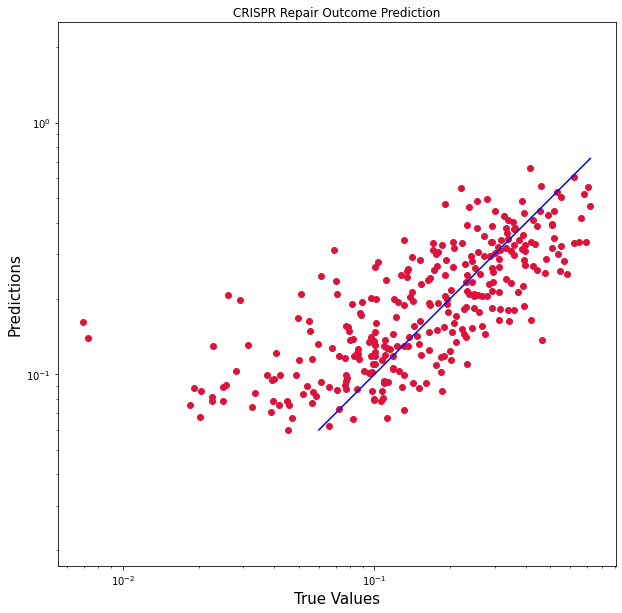

In [33]:
# 최종 테스트 결과 시각화

import matplotlib.pyplot as plt

# 참값 ~ 예측값 catter plot

plt.figure(figsize = (10,10))
plt.scatter(y_label, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred), max(y_label))
p2 = min(min(y_pred), max(y_label))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize = 15)
plt.ylabel('Predictions', fontsize = 15)
plt.axis('equal')
plt.title('CRISPR Repair Outcome Prediction')
plt.show()